# Generalization with Self-organizing Map (SOM) and NeuPy
Using a SOM to recognize handwritten digits from Optical Recognition of
Handwritten Digits Data Set (Lichman, 2003, UCI Machine Learning Repository)

Author: Patricio García

Subject: Tratamiento Inteligente de Datos, ESIT-ULL

License: GNU GPL 3

Date: 03/05/2022

References:
* High-diensional data visualization: Self-Organizing Maps and Applications: http://neupy.com/2017/12/09/sofm_applications.html#high-dimensional-data-visualization
* Generalizacion con LVQ, Patricio García: https://gitlab.com/pgarcia/OptdigitsLVQNeurolab/-/blob/master/Generalizacion_con_LVQ.ipynb


## Carga de librerías
Se utilizan las librerías de numpy, matplotlib y sklearn {Si utilizan cualquier otra comentén específicamente parar qué}:

In [ ]:
# Library imports
# ------------
# Standard scientific Python imports
# python3 -m pip install matplotlib
# python3 -m pip install neupy
# apt-get install python-tk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Import from scikit-learn
# sudo pip install scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Import from NeuPy
# sudo pip install neupy
from neupy import algorithms, utils, init

# Import from datetime
from datetime import datetime

# Increase de figure size
plt.rcParams['figure.dpi'] = 150

## Carga y visualización de datos
Se cargan a memoria los datos, leyendo una parte desde un fichero CSV y otra parta desde las propias librerías de datos de sklearn:

In [3]:
# Patterns load
# ------------
# The digits dataset, train set
digits = np.loadtxt("optdigits.tra", dtype=int, delimiter=',')

(n_samples, n_features) = digits.shape

# The digits dataset, test set
digits_test = datasets.load_digits()

n_samples_test = len(digits_test.images)

print(digits_test.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

Se tratan de datos de dígitos escritos a manos, cada patrón representa un dígito mediante una matriz de 8x8 elementos con valores entre 0 y 16, además incluye una última característica indicando la categoría del dígito, un valor entre 0 y 9. Se puede obtener más información de los datos en su [repostorio oficial](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

El problema a resolver consistirá en identificar la clase del dígito, del 0 al 9, a partir de la matriz de entrada de 8x8.

Visualizamos a continuación 10 de los patrones {Intenten buscar para sus datos alguna manera de visualizarlos, aunque sea como mínimo una tabla numérica con algunos ejemplos}:

Showing first 10 digit images


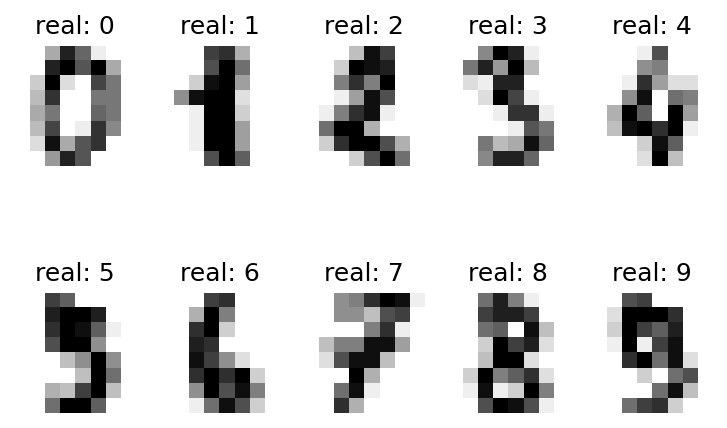

In [4]:
# Data visualization
# ------------
# have a look at the first test images
n_img_plt = 10

print("Showing first %d digit images" % n_img_plt)

_, axes = plt.subplots(2, n_img_plt//2)
images_and_labels = list(zip(digits_test.images[:n_img_plt], digits_test.target[:n_img_plt]))
for ax, (image, label) in zip(np.concatenate(axes), images_and_labels):
    ax.set_axis_off()
    _ = ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    _ = ax.set_title('real: %i' % label)

plt.show()

## Preprocesado de datos
Los datos de entrada serán las imágenes de 8x8 elementos convenientemente preprocesadas, como salida deseada se usa la categoría (el dígito que supuestamente se escribió). {En otros datos habrá de elegirse las entradas y salidas de acuerdo al problema a plantear. Para clasificación es necesario que las salidas sean algún dato categórico. Los errores producidos estarán muy relacionados con el problema a tratar, así por ejemplo detectar el sexo de una persona a partir de los síntomas de la enfermedad que tiene posiblemente sea más complicado que determinar la enfermedad a partir de los síntomas.}

Se realiza una partición de los datos, reservando el 75% de los datos del primer conjunto para entrenamiento, el otro 25% para validación y todos los datos cargados del segundo conjunto para test, {Si tiene un único conjunto de datos a dividir una partición de 50% entrenamiento, 25% validación y 25% test podría estar bien siempre que el conjunto de datos de entrenamiento no quede excesivamente grande o pequeño. Habrá de realizarse una validación con al menos un conjunto de entrenamiento y otro de validación si dispone de pocos datos, una partición de 75% y 25% podría estar bien en ese caso.} Se barajea el cojunto de entrenamiento.

No se realiza escalada de datos de entrada, ya que no se ha visto necesario. {El escalado o nomalización a utilizar es muy dependiente del tipo de problema y tipos de datos de que se disponga, consúltenme si tienen dudas.}

La distribución de datos por clases es bastante homogéneo, por lo tanto se puede considerar bien balanceado. {En el caso de que esto no sea así se podría plantear un balanceo de datos para evitar que las clases con menos datos obtengan malos resultados.} 

In [6]:
# Data preprocessing
# ------------
train_size = 0.75
test_size = 1 - train_size

print("Preprocessing data, %d%% for training and %d%% for validation" % (train_size * 100, test_size * 100))

# inputs and flatten images
patterns_input = digits[:, :n_features-1]
input_test = digits_test.images.reshape((n_samples_test, -1))

# targets
patterns_target = digits[:, -1]
target_test = digits_test.target

# Split and shuffle patterns
input_train, input_valid, target_train, target_valid = train_test_split(
    patterns_input, patterns_target, train_size=train_size, test_size=test_size,
    random_state=0, shuffle=True)

# Print data sets cardinality
print("Number of patterns in train set: %d" % len(target_train))
print("Number of patterns in valid set: %d" % len(target_valid))
print("Number of patterns in test set: %d" % len(target_test))

Preprocessing data, 75% for training and 25% for validation
Number of patterns in train set: 2867
Number of patterns in valid set: 956
Number of patterns in test set: 1797


## Resultados iniciales SOM
Se entrena el modelo SOM con 55 iteraciones, una rejilla de 20x20 y distancia euclídea {. El número de iteraciones puede variar para sus datos, asegúrense que el error de cuantización ha descendido y parece no poder descender mucho más. El tamaño de la rejilla también podría variar en proporción al número de clases finales. El tipo de medida de distancia hay que elegirlo en función de que represente correctamente el parecido entre entradas}:

Learning 20x20 SOM with 25 maximum number of iterations and ...

Main information

[ALGORITHM] SOFM

[OPTION] distance = ['euclid', 'neg_euclid_distance']
[OPTION] features_grid = [20, 20]
[OPTION] grid_type = ['rectangle', 'find_neighbours_on_rect_grid', 'find_step_scaler_on_rect_grid']
[OPTION] learning_radius = 5
[OPTION] n_inputs = 64
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 5
[OPTION] reduce_std_after = 20
[OPTION] reduce_step_after = 20
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] signals = None
[OPTION] std = 1.0
[OPTION] step = 0.5
[OPTION] verbose = True
[OPTION] weight = Normal(mean=0, std=0.01)



#1 : [1 sec] train: 2.557147


#2 : [1 sec] train: 2.518676


#3 : [1 sec] train: 2.497892


#4 : [1 sec] train: 2.479171


#5 : [1 sec] train: 2.315976


#6 : [1 sec] train: 2.319318


#7 : [1 sec] train: 2.313291


#8 : [1 sec] train: 2.306165


#9 : [1 sec] train: 2.285734


#10 : [1 sec] train: 2.113962


#11 : [1 sec] train: 2.113041


#12 : [1 sec] train: 2.106249


#13 : [1 sec] train: 2.109396


#14 : [1 sec] train: 2.096875


#15 : [1 sec] train: 1.895289


#16 : [1 sec] train: 1.881334


#17 : [1 sec] train: 1.873198


#18 : [1 sec] train: 1.873390


#19 : [1 sec] train: 1.864170


#20 : [1 sec] train: 1.654643


#21 : [1 sec] train: 1.648613


#22 : [1 sec] train: 1.646790


#23 : [1 sec] train: 1.639129


#24 : [1 sec] train: 1.641170


#25 : [1 sec] train: 1.290365
Number of seconds for training: 29
Visualizing the Mean Absolute Error Trajectory


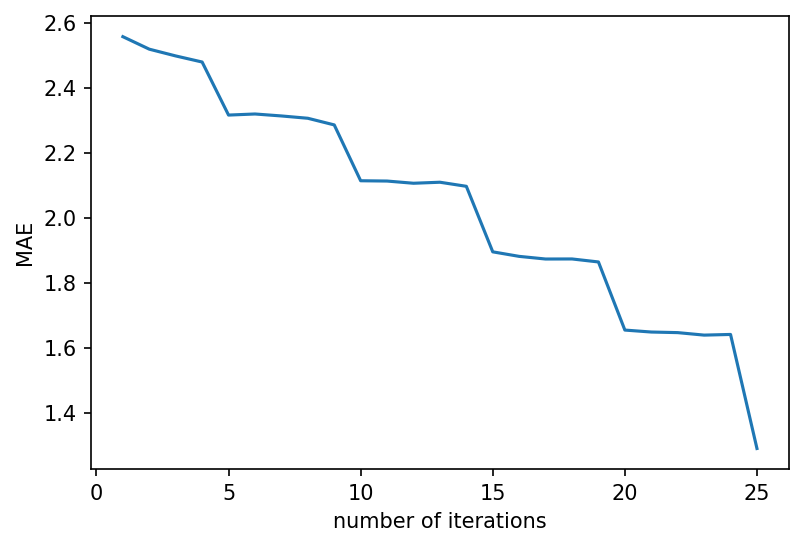

In [8]:
# Modeling SOM
# ------------
max_iter_som = 25
grid_height = 20
grid_width = 20
distance = 'euclid'
learning_radius = 5
step = 0.5
reduce_step_after = max_iter_som - 5
std = 1.0
reduce_std_after = max_iter_som - 5
weight = init.Normal()

print("Learning %dx%d SOM with %d maximum number of iterations and ..." % (grid_height, grid_width, max_iter_som))

now = datetime.now()
# Random generator seed for NeuPy
utils.reproducible(0)

sofm = algorithms.SOFM(
    n_inputs = input_train.shape[1],
    features_grid = (grid_height, grid_width),
    distance = distance,
    weight = weight,
    learning_radius = learning_radius,
    reduce_radius_after = max_iter_som // learning_radius,  # 0 radius at end
    step = step,
    reduce_step_after = reduce_step_after,
    std = std,
    reduce_std_after = reduce_std_after,
    shuffle_data = False,
    verbose = True,
)

sofm.train(input_train, epochs=max_iter_som)
sofm_output_train = sofm.predict(input_train)
sofm_output_valid = sofm.predict(input_valid)
print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())

# Show results
print("Visualizing the Mean Absolute Error Trajectory")
plt.plot(range(1, len(sofm.errors.train)+1), sofm.errors.train)
plt.xlabel('number of iterations')
plt.ylabel('MAE')
plt.show()

Se visualizan a continuación los prototipos de cada una de las neuronas de la rejilla SOM {. Traten de buscar alguna forma de visualizarlos,  aunque sea como mínimo una tabla numérica}:

Building visualization of prototypes grid ...
Progress: 0.00%
Progress: 5.00%
Progress: 10.00%
Progress: 15.00%
Progress: 20.00%
Progress: 25.00%
Progress: 30.00%
Progress: 35.00%
Progress: 40.00%
Progress: 45.00%
Progress: 50.00%
Progress: 55.00%
Progress: 60.00%
Progress: 65.00%
Progress: 70.00%
Progress: 75.00%
Progress: 80.00%
Progress: 85.00%
Progress: 90.00%
Progress: 95.00%


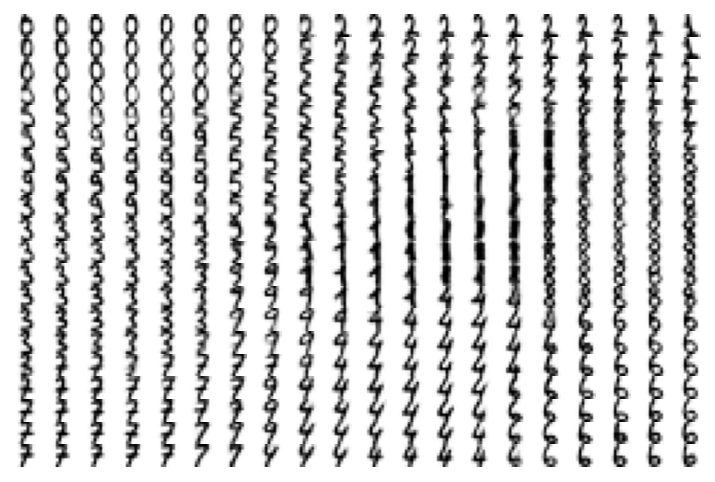

In [9]:
# Prototypes visualization
# ------------
# have a look at the grid

def plot_prototypes_grid(grid_height, grid_width, weight):
    """
    Visualization prototypes of SOM grid
    """
    print("Building visualization of prototypes grid ...")
    grid = gridspec.GridSpec(grid_height, grid_width)
    grid.update(wspace=0, hspace=0)
    for row_id in range(grid_height):
        print("Progress: {:.2%}".format(row_id / grid_height))
        for col_id in range(grid_width):
            index = row_id * grid_width + col_id
            sample = weight[:,index]
            _ = plt.subplot(grid[index])
            _ = plt.imshow(sample.reshape((8, 8)), cmap='Greys')
            _ = plt.axis('off')
    plt.show()

plot_prototypes_grid(grid_height, grid_width, sofm.weight)

En el mapa de prototipos se ve que casi todas las distintas clases se encuentran en regiones diferentes, no apreciándose problemas de dobleces u otros.

## Resultados iniciales Counterpropagation
Se entrena el modelo Perceptrón Simple con 30 iteraciones teniendo como entradas las salidas de SOM, lo que simula una red Counterpropagation {. El número de iteraciones puede variar para sus datos, asegúrense que el error de pérdidas de cada clase ha descendido y parece no poder descender mucho más}:

In [10]:
# Modeling Perceptron
# ------------
# Perceptron use de SOM output (grid array of 0 except winning output).
# That is, Counterpropagation Network (CPN)

max_iter_per = 30

print("Learning a Perceptron with %d maximum number of iterations and ..." % max_iter_per)

per = Perceptron(max_iter=max_iter_per, shuffle=False, random_state=0, verbose=True)
per.fit(sofm_output_train, target_train)

Learning a Perceptron with 30 maximum number of iterations and ...
-- Epoch 1
Norm: 13.38, NNZs: 90, Bias: -1.000000, T: 2867, Avg. loss: 0.010813
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 13.89, NNZs: 93, Bias: -1.000000, T: 5734, Avg. loss: 0.000349
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 14.11, NNZs: 94, Bias: -1.000000, T: 8601, Avg. loss: 0.000349
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 14.32, NNZs: 95, Bias: -1.000000, T: 11468, Avg. loss: 0.000349
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 14.53, NNZs: 96, Bias: -1.000000, T: 14335, Avg. loss: 0.000349
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 14.73, NNZs: 97, Bias: -1.000000, T: 17202, Avg. loss: 0.000349
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 14.93, NNZs: 98, Bias: -1.000000, T: 20069, Avg. loss: 0.000349
Total training time: 0.07 seconds.
Convergence after 7 epochs took 0.07 seconds
-- Epoch 1
Norm: 17.18, NNZs: 135, Bias: -1.000000, T: 2867, Avg. loss: 0.02197

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 16.70, NNZs: 126, Bias: -1.000000, T: 2867, Avg. loss: 0.019184
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 18.36, NNZs: 137, Bias: -1.000000, T: 5734, Avg. loss: 0.005232
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 19.97, NNZs: 147, Bias: -1.000000, T: 8601, Avg. loss: 0.004534
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 21.05, NNZs: 156, Bias: -1.000000, T: 11468, Avg. loss: 0.005581
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 21.70, NNZs: 160, Bias: -1.000000, T: 14335, Avg. loss: 0.006278
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 22.34, NNZs: 164, Bias: -1.000000, T: 17202, Avg. loss: 0.006278
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 22.80, NNZs: 168, Bias: -2.000000, T: 20069, Avg. loss: 0.006627
Total training time: 0.02 seconds.
Convergence after 7 epochs took 0.02 seconds
-- Epoch 1
Norm: 17.58, NNZs: 143, Bias: -1.000000, T: 2867, Avg. loss: 0.020928
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 20.05, NNZs: 159,

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


Perceptron(max_iter=30, shuffle=False, verbose=True)

In [11]:
# Intitial results
# ------------
print("Printing initial results")

predict_train = per.predict(sofm_output_train)
predict_valid = per.predict(sofm_output_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))

Printing initial results
Train accuracy: 98.151%
Valid accuracy: 97.908%
Train confusion matrix:
[[274   0   0   0   1   0   0   0   0   0]
 [  0 286   1   0   1   0   0   0   0   1]
 [  0   2 282   0   0   0   0   0   0   0]
 [  0   0   0 285   0   4   0   1   2   3]
 [  0   0   0   0 294   0   2   1   0   2]
 [  0   0   0   0   0 287   0   0   0   3]
 [  0   2   0   0   0   0 279   0   0   0]
 [  0   0   0   1   4   0   0 287   0   0]
 [  0   7   0   0   1   0   0   0 272   1]
 [  0   0   0   2   7   1   0   2   1 268]]
Valid confusion matrix:
[[100   0   0   0   0   0   1   0   0   0]
 [  0  98   0   0   0   0   0   0   0   2]
 [  1   0  95   0   0   0   0   0   0   0]
 [  0   0   0  93   0   1   0   0   0   0]
 [  0   0   0   0  84   0   1   0   0   3]
 [  0   0   0   0   0  86   0   0   0   0]
 [  0   1   0   0   0   0  95   0   0   0]
 [  0   0   0   0   0   0   0  95   0   0]
 [  0   1   0   1   0   0   0   0  97   0]
 [  0   1   0   1   3   2   0   0   1  93]]
Train classificat

Los resultados aparentan ser buenos, las matrices de cruces tiene la mayoría del peso en la diagonal principal y para todas las clases se obtiene buenas precisions y recalls. {En caso de que esto no sea así deberían plantearse qué problema puede estar ocurriendo y tratar de solventarlo.}

## Optimización arquitectura SOM
Para tratar de mejorar los resultados del CPN se estudia las dimensiones de la rejilla SOM más adecuadas, probando con distintos valores entre 10 y 190, repitiendo parar cada configuración 5 veces y quedándose con aquella de mayor precisión en el conjunto de validación {. Las dimensiones de la rejilla a estudiar deben adaptarlas a sus datos, de forma que haya variabilidad en los resultados obtenidos. Este estudio puede conllevar mucho tiempo de cómputo}:

In [12]:
# Architecture optimization
# ------------
print("Architecture optimization")

# Test SOM with differents number of grid units and several repetitions
tests_grid_side = [5, 10, 15, 20, 25, 30, 35]
n_reps = 5

now = datetime.now()
best_sofm = []
best_per = []
best_acc = 0.0
accs_train = []
accs_valid = []
for grid_side in tests_grid_side:
    max_acc_train = max_acc_valid = 0.0
    for random_state in range(n_reps):
        utils.reproducible(random_state)
        sofm = algorithms.SOFM(n_inputs = input_train.shape[1], features_grid = (grid_side, grid_side), distance = distance, weight = weight, learning_radius = learning_radius, reduce_radius_after = max_iter_som // learning_radius, step = step, reduce_step_after = reduce_step_after, std = std, reduce_std_after = reduce_std_after, shuffle_data = False, verbose = False)
        sofm.train(input_train, epochs=max_iter_som)
        sofm_output_train = sofm.predict(input_train)
        sofm_output_valid = sofm.predict(input_valid)
        per = Perceptron(max_iter=max_iter_per, shuffle=False, random_state=random_state, verbose=False)
        _ = per.fit(sofm_output_train, target_train)
        acc_train = accuracy_score(target_train, per.predict(sofm_output_train))
        acc_valid = accuracy_score(target_valid,per.predict(sofm_output_valid))
        print("Seed = %d, train acc = %.8f, valid acc = %.8f" % (random_state, acc_train, acc_valid))
        if (max_acc_valid < acc_valid):
            max_acc_valid = acc_valid
            max_acc_train = acc_train
            if (acc_valid > best_acc):
                best_acc = acc_valid
                best_per = per
                best_sofm = sofm
    accs_train.append(max_acc_train)
    accs_valid.append(max_acc_valid)
    print("Grid size = %ix%i, train acc = %.8f, max valid acc = %.8f" % (grid_side, grid_side, max_acc_train, max_acc_valid))

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best CPN valid accuracy: %.8f%%" % (best_acc * 100))
print("Best SOM: ", best_sofm)
print("Best Perceptron: ", best_per)

Architecture optimization


Seed = 0, train acc = 0.87199163, valid acc = 0.86401674


Seed = 1, train acc = 0.87199163, valid acc = 0.86401674


Seed = 2, train acc = 0.87199163, valid acc = 0.86401674


Seed = 3, train acc = 0.87199163, valid acc = 0.86401674


Seed = 4, train acc = 0.87199163, valid acc = 0.86401674
Grid size = 5x5, train acc = 0.87199163, max valid acc = 0.86401674


Seed = 0, train acc = 0.94768050, valid acc = 0.94769874


Seed = 1, train acc = 0.94244855, valid acc = 0.94037657


Seed = 2, train acc = 0.93930938, valid acc = 0.94142259


Seed = 3, train acc = 0.94733171, valid acc = 0.94351464


Seed = 4, train acc = 0.94942449, valid acc = 0.94560669
Grid size = 10x10, train acc = 0.94768050, max valid acc = 0.94769874


Seed = 0, train acc = 0.96407394, valid acc = 0.96234310


Seed = 1, train acc = 0.96965469, valid acc = 0.97071130


Seed = 2, train acc = 0.97209627, valid acc = 0.96861925


Seed = 3, train acc = 0.96756191, valid acc = 0.96652720


Seed = 4, train acc = 0.97314266, valid acc = 0.97175732
Grid size = 15x15, train acc = 0.97314266, max valid acc = 0.97175732


Seed = 0, train acc = 0.98151378, valid acc = 0.97907950


Seed = 1, train acc = 0.97663062, valid acc = 0.97384937


Seed = 2, train acc = 0.97837461, valid acc = 0.96129707


Seed = 3, train acc = 0.97139867, valid acc = 0.96548117


Seed = 4, train acc = 0.97697942, valid acc = 0.96652720
Grid size = 20x20, train acc = 0.98151378, max valid acc = 0.97907950


Seed = 0, train acc = 0.98186257, valid acc = 0.97280335


Seed = 1, train acc = 0.98500174, valid acc = 0.96966527


Seed = 2, train acc = 0.97907220, valid acc = 0.96757322


Seed = 3, train acc = 0.98081618, valid acc = 0.96966527


Seed = 4, train acc = 0.98360656, valid acc = 0.97280335
Grid size = 25x25, train acc = 0.98186257, max valid acc = 0.97280335


Seed = 0, train acc = 0.98779212, valid acc = 0.95815900


Seed = 1, train acc = 0.98709452, valid acc = 0.96443515


Seed = 2, train acc = 0.98779212, valid acc = 0.96025105


Seed = 3, train acc = 0.98081618, valid acc = 0.95606695


Seed = 4, train acc = 0.98186257, valid acc = 0.95397490
Grid size = 30x30, train acc = 0.98709452, max valid acc = 0.96443515


Seed = 0, train acc = 0.98848971, valid acc = 0.94246862


Seed = 1, train acc = 0.98814091, valid acc = 0.94874477


Seed = 2, train acc = 0.98988490, valid acc = 0.94769874


Seed = 3, train acc = 0.98918730, valid acc = 0.94560669


Seed = 4, train acc = 0.98883851, valid acc = 0.94769874
Grid size = 35x35, train acc = 0.98814091, max valid acc = 0.94874477
Number of seconds for training: 1165
Best CPN valid accuracy: 97.90794979%
Best SOM:  SOFM(verbose=False, step=0.5, show_epoch=1, shuffle_data=False, signals=None, n_inputs=64, n_outputs=400, weight=(64, 400), features_grid=[20, 20], distance=['euclid', 'neg_euclid_distance'], grid_type=['rectangle', 'find_neighbours_on_rect_grid', 'find_step_scaler_on_rect_grid'], learning_radius=5, std=1.0, reduce_radius_after=5, reduce_std_after=20, reduce_step_after=20)
Best Perceptron:  Perceptron(max_iter=30, shuffle=False, verbose=False)


Se observa que la mejor rejilla encontrada resulta ser de 15x15 neuronas en la capa oculta. Se visualizan los resultados de errores obtenidos con las distintas arquitecturas estudiadas {. Utilicen un rango de neuronas ocultas en que se vea empeoramiento del error en sus valores más bajos y variaciones poco significativas en valores más altos. Nunca la mejor rejilla encontrada debe estar en un extremo del intervalo}:

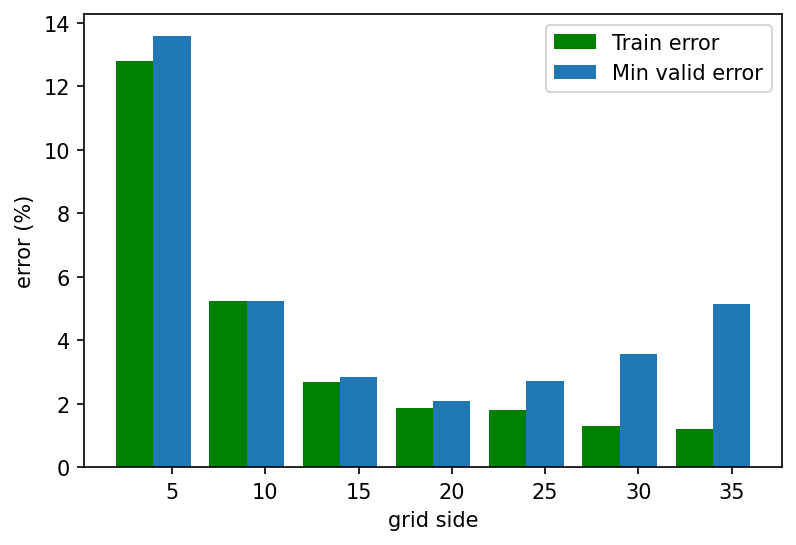

In [13]:
# Show results
width = 2
plt.bar(np.array(tests_grid_side) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_grid_side), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('grid side')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_grid_side), tests_grid_side)
plt.legend(loc='upper right')
plt.show()

Se observa que rejillas entre 15x15 y 30x30 los resultados son similares, con variaciones poco significativas. {Si consideran mejor algún otro CPN no duden en utilizarlo.}

## Resultados finales mejor CPN
Se calculan los resultados finales para el mejor CPN obtenido, incluido el conjunto de test {Es importante no haber utilizado nunca el conjunto de test como guía para ajustar la arquitectura o parámetros}:

In [14]:
print("Printing final results")

sofm_output_train = best_sofm.predict(input_train)
sofm_output_valid = best_sofm.predict(input_valid)
sofm_output_test = best_sofm.predict(input_test)
predict_train = best_per.predict(sofm_output_train)
predict_valid = best_per.predict(sofm_output_valid)
predict_test = best_per.predict(sofm_output_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Printing final results
Train accuracy: 98.151%
Valid accuracy: 97.908%
Test accuracy: 97.162%
Train confusion matrix:
[[274   0   0   0   1   0   0   0   0   0]
 [  0 286   1   0   1   0   0   0   0   1]
 [  0   2 282   0   0   0   0   0   0   0]
 [  0   0   0 285   0   4   0   1   2   3]
 [  0   0   0   0 294   0   2   1   0   2]
 [  0   0   0   0   0 287   0   0   0   3]
 [  0   2   0   0   0   0 279   0   0   0]
 [  0   0   0   1   4   0   0 287   0   0]
 [  0   7   0   0   1   0   0   0 272   1]
 [  0   0   0   2   7   1   0   2   1 268]]
Valid confusion matrix:
[[100   0   0   0   0   0   1   0   0   0]
 [  0  98   0   0   0   0   0   0   0   2]
 [  1   0  95   0   0   0   0   0   0   0]
 [  0   0   0  93   0   1   0   0   0   0]
 [  0   0   0   0  84   0   1   0   0   3]
 [  0   0   0   0   0  86   0   0   0   0]
 [  0   1   0   0   0   0  95   0   0   0]
 [  0   0   0   0   0   0   0  95   0   0]
 [  0   1   0   1   0   0   0   0  97   0]
 [  0   1   0   1   3   2   0   0   1  9

Se observa que los resultados finales del mejor CPN obtenido para el conjunto de validación mejoran respecto al los resultados iniciales en un 1,15%, mejorando la generalización respecto al CPN inicial. El error final parar el conjunto de test es un 1,54% peor que el conjunto de validación. En la matriz de confusión y el informe de clasificación del conjunto de test se aprecia que todas la clases se reconocen mas o menos bien, la clase con mayores problema de reconocimiento es la que corresponde al dígito 8.

Se muestran también las curvas ROC para el conjunto de test, en ella también se puede ver que la clase del dígito 8 es la peor predicha:

Printing ROC curves of test set


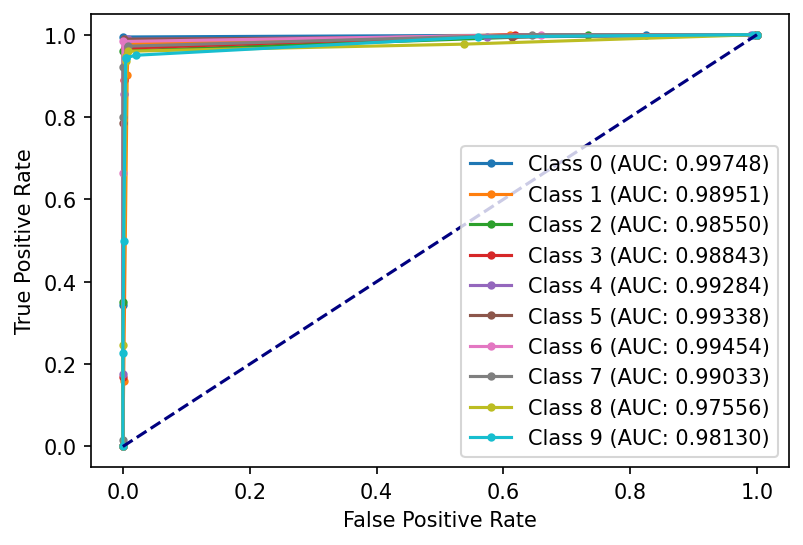

In [15]:
# ROC curves of test set
per_probs = best_per.decision_function(sofm_output_test)
classes  = np.unique(target_train)
per_auc = []
per_fpr = []
per_tpr = []
for cla in classes:
   per_auc.append(roc_auc_score(target_test==cla, per_probs[:,cla]))
   fpr, tpr, _ = roc_curve(target_test==cla, per_probs[:,cla])
   per_fpr.append(fpr)
   per_tpr.append(tpr)

print("Printing ROC curves of test set")
# plot the roc curve for the model
for cla in classes:
   # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
   _ = plt.plot(per_fpr[cla], per_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, per_auc[cla]))

# axis labels
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Building visualization of prototypes grid ...
Progress: 0.00%
Progress: 5.00%
Progress: 10.00%
Progress: 15.00%
Progress: 20.00%
Progress: 25.00%
Progress: 30.00%
Progress: 35.00%
Progress: 40.00%
Progress: 45.00%
Progress: 50.00%
Progress: 55.00%
Progress: 60.00%
Progress: 65.00%
Progress: 70.00%
Progress: 75.00%
Progress: 80.00%
Progress: 85.00%
Progress: 90.00%
Progress: 95.00%


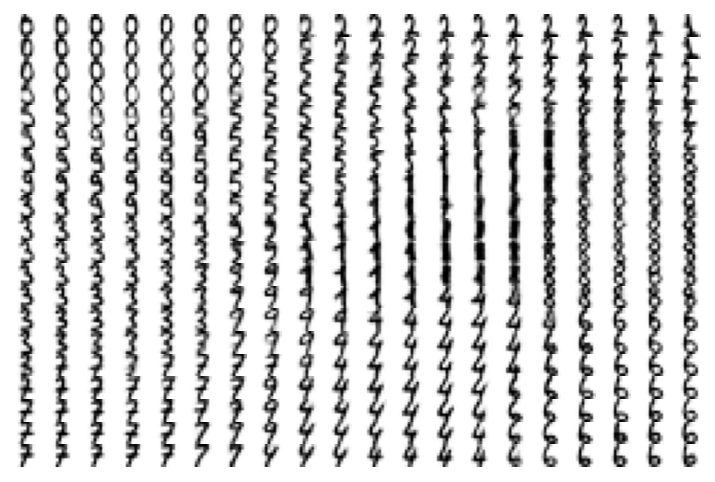

In [16]:
# Show grid prototypes
plot_prototypes_grid(best_sofm.features_grid[0], best_sofm.features_grid[1], best_sofm.weight)

En el mapa de prototipos se sigue viendo que casi todas las distintas clases se encuentran en regiones diferentes, no apreciándose problemas de dobleces u otros.

Finalmente se muestran imágenes de distintos errores producidos en patrones del conjunto de test pertenecientes a la clase real 8:

Showing first 8 errors of real class 8


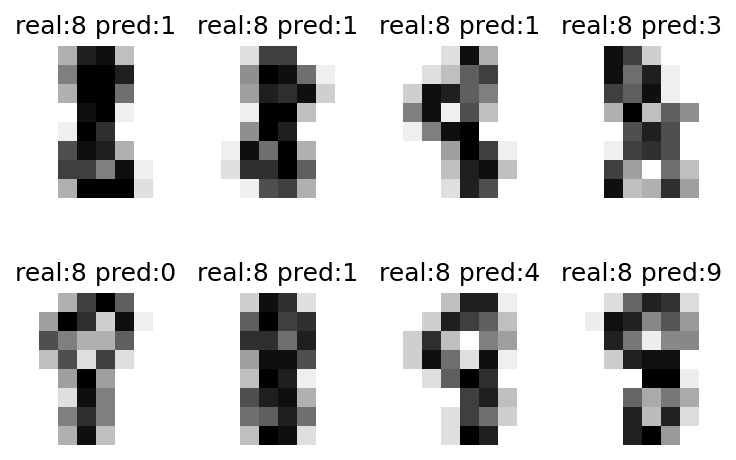

In [17]:
# Show errors on real class 8
real_class = 8
indxs = np.where(digits_test.target == real_class)[0]
indxs_err = indxs[(np.where(predict_test[(indxs)] != real_class)[0])]
preds_err = predict_test[(indxs_err)]
n_img_plt = 8

print("Showing first %d errors of real class %d" % (n_img_plt, real_class))

_, axes = plt.subplots(2, n_img_plt//2)
images_and_labels = list(zip(digits_test.images[(indxs_err)], digits_test.target[(indxs_err)], preds_err))
for ax, (image, label1, label2) in zip(np.concatenate(axes), images_and_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('real:%i pred:%i' % (label1, label2))

plt.show()

## Conclusiones
El error final parar el conjunto de test, mucho peor que el conjunto de validación, puede estar justificado en parte debido a que los autores (escritores) del conjuntos de test son distintos a los autores de los conjuntos de entrenamieto y validación, donde si son los mismos. Los problemas que se aprecia que con el dígito 8 resultas ser lógicos, en la medida que la representación de un número tan denso en una matriz tan escasa resulta complicada, como se observa en la imagne de dichos errores. Esto nos induce a pensar que utilizando matrices mas grandes, como por ejemplo las utilizadas en el conjunto de datos MINIST, se podrían obtener resultados aún mejores.

Este resultado final parece bastante aceptable, es similar al obtenido con el Perceptrón Multicapa en una actividad anterior, arquitectura mas compleja que el CPN, y por ejemplo supera en 2,23% al mejor resultado obtenido en la publicación (Tang, Ponnuthurai, Suganthan, Yao and Qin, 2005) (93,93% de accurracy con WLDR 9d). {Si pueden comparar los resultados por los publicados por otros autores, mucho mejor.}